# Figures 7 & 8, and Figures S5 to S9 - Cloud fractions and heating rates 

In this script, we follow the framework described in Jenney et al (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002056)

We derive the variables needed in equations 8-10 in the paper (e.g. heating rates, gamma, etc.) for each model, at each temperature. As we are interested in fractional changes with warming, these are calculated at temperatures 300K, and 305K and saved in arrays for analysis. The dynamic components of these temperature changes are also calculated and stored.

This script produces:
- Figure 7 and Fig S5: fractional changes in high (Fig. 7) and low (Fig. S5) cloud fraction with warming, plotted against the fractional changes in ascent fraction, and the longwave and shortwave dynamic components of the cloud feedback
- Figure 8: how different components of equations 8-10 relate to fractional changes in ascent fraction
- Figs S6-S8: probing how well the approximations of ascent fraction (and fractional changes in ascent fraction) are able to approximate the simulated changes
- Fig S9 as Figure 8, but for longwave dynamic component of the cloud feedback rather than ascent fraction

In [7]:
import sys
import pathlib
import platform
venv_path = '~/nb-venvs/metpy_venv'
sys.path.append(str(pathlib.Path(f'{venv_path}/lib/python{platform.python_version_tuple()[0]}.{platform.python_version_tuple()[1]}/site-packages/').expanduser()))

import metpy
print(metpy.__file__)

/home/users/arm33/nb-venvs/metpy_venv/lib/python3.10/site-packages/metpy/__init__.py


In [11]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from metpy.calc import saturation_mixing_ratio
from metpy.units import units
from scipy import stats
import matplotlib.lines as mlines
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

import sys
sys.path.append('../')
import funcs

models = ['CM1',  'dam','ICON_LEM_CRM', 'ICON_NWP_CRM', 'MESONH', 'SAM_CRM', 'SCALE', 'UCLA-CRM',
          'UKMOi-vn11.0-CASIM', 'UKMOi-vn11.0-RA1-T', 'UKMOi-vn11.0-RA1-T-nocloud', 'WRF_COL_CRM']


m = len(models)
cols =  np.load('color_grid.npy', allow_pickle = True)


# limits of vertical velocity, common across models
pl = 0.22 # pos limit
nlim= -0.07 # neg limit
bs = 0.001 # bin size

bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of vertical velocity bins: ', b)
mnbin = [] # create array of the mid-point between bin limits for plotting
for i in range(1,b):
    mnbin = np.append(mnbin, np.mean([bins[i-1], bins[i]])*100)
    
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)' 'j)' 'k)', 'l)']    
temps = ['large295', 'large300', 'large305']
    
s_in_day = 60*60*24 # number of seconds in a day, used for unit conversions
ms = 8 # markersize

no of vertical velocity bins:  291


### Analysis outline

This code loops through all the models, and caclulates variables for the two temperature differences (305-300K, 300-295K). It saves calculated variables to arrays for analysis below.

The basic outline is:
- define empty arrays for holding fractional changes of variables for each model
- loop through models
- for each model, define empty arrays to hold variables at each temperature
- loop through temperatures and at each temperature, calculate the key variables
- at 300K and 305K, calculate the fractional changes between that temperature and the temperature below, place in fractional change array

During this first part, two SI Figures are produced. Beta1, beta2 and beta3 (see equations 8-10 in paper) are also calculated for Fig S8.

### Figures S6 & S7
Figure S6 shows signs of heating rate components and relative size of Q_down against Q_up, and Q^r_up against Q^c_up

Figure S7 plots the approximation of alpha_up from the Jenney approximation, against the model simulated values, and similar for the fractional changes in alpha_up

CM1


/home/users/arm33/RCEMIP/allMod/../funcs.py:120: RuntimeWarning: Mean of empty slice
  arrbin = [np.nanmean(arr[dig==i]) for i in range(1,b)]


dam
ICON_LEM_CRM
ICON_NWP_CRM
MESONH
SAM_CRM
SCALE
UCLA-CRM
UKMOi-vn11.0-CASIM
UKMOi-vn11.0-RA1-T
UKMOi-vn11.0-RA1-T-nocloud
WRF_COL_CRM
slope is:  0.9614538515718901  and standard error is: 0.01893114891772782
slope is:  0.9647466855530001  and standard error is: 0.023989543296508844


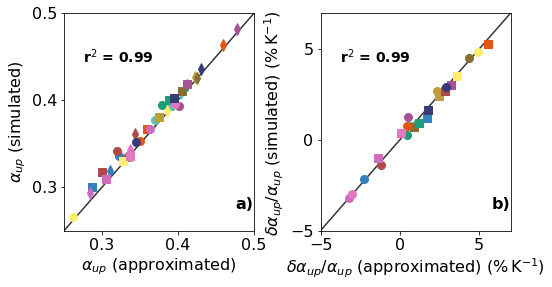

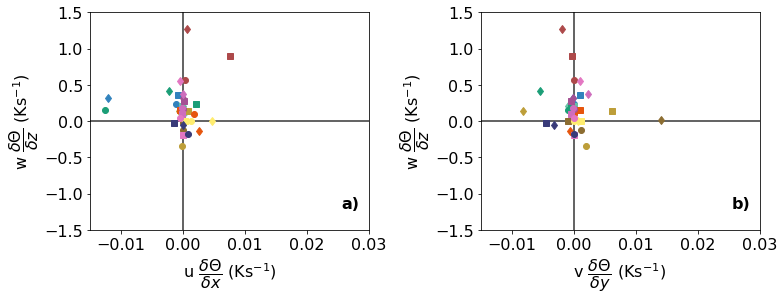

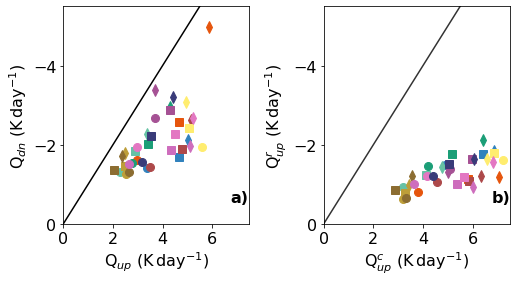

In [13]:
""" Fractional change array set up. These are for holding the fractional changes in variables for each model, 
for the two temperature changes"""

# arrays for heating rates, alpha_up, cloud fractions, stability, gamma, and dynamic components
r_alpha_up, r_Qup, r_Qdn, r_diff_up_down, r_Qrup, r_Qcup, r_diff_c_r = [],[],[],[],[],[],[]
r_HCF, r_LCF, r_precip = [],[],[]
r_stab_up, r_stab_dn, r_gamma = [],[],[]
r_dynSW, r_dynLW = [], []

# For SI Figure 4
SIax1a, SIax1b, SIax2a, SIax2b = [],[],[],[]

# for apprximations of alpha_up
b1_stack, b2_stack, b3_stack, b4_stack = [],[], [], []

# For horizontal components (not used)
u_stack, v_stack, w_stack = [],[],[]

##### SI Figure set up #####


# SI Figure 5
fig, ax = plt.subplots(1,2)

lim = [0.25, 0.5]
FClim = [-5, 7]

ax[0].plot(lim,lim, 'k-',alpha = 0.8)
ax[1].plot(FClim, FClim, 'k-', alpha = 0.8)

# plot showing horizontal terms are small - not used in final paper
fig1, ax1 = plt.subplots(1,2)
lim1xa, lim1xb = -1.5E-2, 3E-2
lim1ya, lim1yb = -1.5, 1.5
for i in range(2):
    ax1[i].plot([lim1xa, lim1xb], [0,0], 'k-', alpha = 0.8)
    ax1[i].plot([0,0], [lim1ya, lim1yb], 'k-', alpha = 0.8)

#SI Figure 4 plot showing that Qup positive, Qdn negative and Qcup positive and Qrup negative  
fig2, ax2 = plt.subplots(1,2)
  
markers = ['o', 's', 'd']
pLev = 500
deltaT = 5
crf = 'lwcrf'

###############

# Loop through models
k = 0
for model in models:
    
    # empty arrays for filling with model specific variables
    real_alpha_up_stack, alpha_up_stack = [], []
    Qup_stack, Qdn_stack, gamma_stack, Qupdn_stack = [],[], [], []
    HCF_stack, LCF_stack, precip_stack = [],[],[]
    Qcup_stack, Qrup_stack = [],[]
    stab_up_stack, stab_dn_stack = [], []
    
    print(model)
    
    
    dp = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/'
    dp2 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/'
    
    for i in range(3): # loop over temps
        marker = markers[i]
        
        # load data for model at that temp
        pa = np.load(dp + temps[i] + 'pa_profile_25d.npy', allow_pickle = True)/100
        if i==0:
            wa500_alltemp = np.empty((3,np.shape(pa)[0],np.shape(pa)[2], np.shape(pa)[3]))
        wa = np.load(dp + temps[i] + 'wa_profile_25d.npy', allow_pickle = True)
        tntr = np.load(dp + temps[i] + 'tntr_profile_25d.npy', allow_pickle = True)
        ta = np.load(dp + temps[i] + 'ta_profile_25d.npy', allow_pickle = True)
        hus = np.load(dp + temps[i] + 'hus_profile_25d.npy', allow_pickle = True)
        cldfrac =  np.load(dp  + temps[i] + 'cldfrac_profile_25d.npy', allow_pickle = True)
        pr = np.load(dp2 + temps[i] + 'pr24hrs.npy', allow_pickle = True)
        ua = np.load(dp + temps[i] + 'ua_profile_25d.npy', allow_pickle = True)
        va = np.load(dp + temps[i] + 'va_profile_25d.npy', allow_pickle = True)
        
        
        #add units
        wa = np.asarray(wa) * units.meter / units.second
        pa = np.asarray(pa) * units.hPa
        ta = np.asarray(ta) * units.K
        hus = np.asarray(hus) * units.gram / units.gram
        Qr = np.asarray(tntr) * units.K / units.second

        #derive quantities
        wap = metpy.calc.vertical_velocity_pressure(wa, pa, ta, hus)
        wap = wap.to(units.hectopascal / units.second) # vertical velocity in units of hPa /s
        theta = metpy.calc.potential_temperature(pa, ta) # potential temperature
        stab = metpy.calc.first_derivative(theta, axis = 1, x = pa)* (-ta / theta) # stability

        wstab = wap*stab    
        Qc = -wstab - Qr    # obtain Qc from eq 4/5 in paper

        # horizontal components
        zr = metpy.calc.pressure_to_height_std(pa)
        yr = np.arange(0, 96*np.shape(wa)[2], 96) * units.km # add units
        xr = np.arange(0, 96*np.shape(wa)[3], 96) * units.km
        
        theta = metpy.calc.potential_temperature(pa, ta)
        dth_dz = metpy.calc.first_derivative(theta, axis = 1, x = zr)
        dth_dy = metpy.calc.first_derivative(theta, axis = 2, x = yr)
        dth_dx = metpy.calc.first_derivative(theta, axis = 3, x = xr) # units of K/km
        
        # remove units for following calculations
        wa = np.asarray(wa)
        Qc = np.asarray(Qc)
        Qr = np.asarray(Qr)
        pa = np.asarray(pa)
        stab = np.asarray(stab)
        dth_dz = np.asarray(dth_dz)*1000 # units of K/m
        dth_dy = np.asarray(dth_dy)*1000
        dth_dx = np.asarray(dth_dx)*1000    
        
        # obtain variables at the p= 500 level 
        # (uses the method of finding the model level closest to 500hPa at each gridpoint)
        stab = funcs.getPlevel(stab, pa, pLev)
        Qc = funcs.getPlevel(Qc, pa, pLev)
        Qr = funcs.getPlevel(Qr, pa, pLev)
        wa500 = funcs.getPlevel(wa, pa, pLev)             
        wa500_alltemp[i,] = wa500
        
        # horizontal terms 
        ua500 = funcs.getPlevel(ua, pa, pLev)             
        va500 = funcs.getPlevel(va, pa, pLev)
        
        dth_dz = funcs.getPlevel(dth_dz, pa, pLev)             
        dth_dy = funcs.getPlevel(dth_dy, pa, pLev)             
        dth_dx = funcs.getPlevel(dth_dx, pa, pLev)     
        
        ax1[0].plot(np.mean(ua500)*np.mean(dth_dx),np.mean(wa500)*np.mean(dth_dz) ,marker = marker, color = cols[k])
        ax1[1].plot(np.mean(va500)*np.mean(dth_dy),np.mean(wa500)*np.mean(dth_dz) ,marker = marker, color = cols[k])
        
        u_stack = np.append(u_stack, np.mean(ua500)*np.mean(dth_dx))
        v_stack = np.append(v_stack, np.mean(va500)*np.mean(dth_dy))
        w_stack = np.append(w_stack, np.mean(wa500)*np.mean(dth_dz))
        
        # split Q field into ascending and descending groups 
        Qcup = Qc[(wa500 > 0)]
        Qr_up = np.mean(Qr[(wa500>0)]) 
        Qr_dn = np.mean(Qr[(wa500<0)])
        Qc_dn = np.mean(Qc[(wa500<0)])
        Qc_up = np.mean(Qc[(wa500>0)])
        
        Qup = Qc_up + Qr_up
        Qdn = Qc_dn + Qr_dn
        
        # plot for SI Fig 4
        ax2[0].plot(Qup*s_in_day, Qdn*s_in_day, marker = marker, color = cols[k], markersize = ms)
        ax2[1].plot(Qc_up*s_in_day, Qr_up*s_in_day, marker = marker, color = cols[k], markersize = ms)
        
        # calculate alpha up using Jenney approximation
        Qratio = Qup/Qdn

        stab_up = np.mean(stab[(wa500 >0)]) # stability in ascnet region
        stab_dn = np.mean(stab[(wa500 <0)]) # stability in descent region
        gamma = stab_dn/stab_up # gamma as defined in paper
        #print('gamma: ', gamma)
        alpha_up = 1/(1 - gamma*Qratio) # approximation of alpha_up
        real_alpha_up = funcs.calcFup(wa500) # model simulated alpha_up 
        
        # plot for SI Fig 5
        ax[0].plot(alpha_up, real_alpha_up, marker = marker, color = cols[k], markersize = ms)
        SIax1a = np.append(SIax1a, alpha_up)
        SIax1b = np.append(SIax1b, real_alpha_up)
        
        
        ### precipitation and cloud fraction ###
        
        # precip - whole domain mean, not used in paper
        precip = np.mean(pr[(wa500 >0)])
    
        # define cloud fractions as low (peak below 500hPa) and high (above 500hPa) 
        
        pa_prof = np.mean(pa, axis = (0,2,3)) # mean full pressure profile
        p1 = np.argmin(abs(pa_prof - 500)) # find pressure levels correpsonding to 500 and 1000 hPa
        p2 = np.argmin(abs(pa_prof - 1000))

        if p1 < p2:
            st, en = p1,p2
        else:
            en,st = p1, p2
            
        LCF = np.mean(cldfrac[:,st:en,]) # low cloud fraction between 500 - 1000 hPa
        
        # define high cloud fraction as between 500-100 hPa
        p1 = np.argmin(abs(pa_prof - 100))
        p2 = np.argmin(abs(pa_prof - 500))

        if p1 < p2:
            st, en = p1,p2
        else:
            en,st = p1, p2
            
        HCF = np.max(np.mean(cldfrac[:,st:en,], axis = (0,2,3)))
    
        
        ### append to arrays ###
        # For each temperature, append the variables to the relavent array, for further calculation later
        Qup_stack = np.append(Qup_stack, Qup)
        Qdn_stack = np.append(Qdn_stack, Qdn)
        
        Qcup_stack = np.append(Qcup_stack, Qc_up)
        Qrup_stack = np.append(Qrup_stack, Qr_up)
        
        alpha_up_stack = np.append(alpha_up_stack, alpha_up) # approximated alpha up
        real_alpha_up_stack = np.append(real_alpha_up_stack, real_alpha_up)
        
        stab_up_stack = np.append(stab_up_stack, stab_up)
        stab_dn_stack = np.append(stab_dn_stack, stab_dn)

        # for showing changes in gamma are small
        Qupdn_stack = np.append(Qupdn_stack, Qup/Qdn) # ratio of Qup and down
        gamma_stack = np.append(gamma_stack, gamma)
        
        #cloud and precip
        HCF_stack = np.append(HCF_stack, HCF)
        LCF_stack = np.append(LCF_stack, LCF)
        precip_stack = np.append(precip_stack, precip)
        
        """now looking at temperature differences 
        (ie when temp = 300K, look at 300-295K, when temp = 305K, look at 305-300K"""
        
        if i==1 or i==2:
            if i==1:
                con,new = '295', '300'
                marker = 'o'

            if i==2:
                con,new = '300', '305'
                marker = 's'

            #### calculate fractional changes in variables ###
            
            # approx and simulated alpha_up for SI Figure 5
            FCalpha_up = funcs.fracChange(alpha_up_stack[i], alpha_up_stack[i-1], deltaT)
            FCreal_alpha_up = funcs.fracChange(real_alpha_up_stack[i], real_alpha_up_stack[i-1], deltaT)
            
            ax[1].plot(FCalpha_up, FCreal_alpha_up, marker = marker, color = cols[k], markersize = ms)
            # append fractional changes in approximated and simulated alpha_up for correlation calculations below
            SIax2a = np.append(SIax2a, FCalpha_up)
            SIax2b = np.append(SIax2b, FCreal_alpha_up)
            
            # fractional changes in heating rates, stability and gamma
            FCQup = funcs.fracChange(Qup_stack[i], Qup_stack[i-1],deltaT)
            FCQdn = funcs.fracChange(Qdn_stack[i], Qdn_stack[i-1],deltaT)
            FCQrup = funcs.fracChange(Qrup_stack[i], Qrup_stack[i-1], deltaT)
            FCQcup = funcs.fracChange(Qcup_stack[i], Qcup_stack[i-1], deltaT)
            FCstabup = funcs.fracChange(stab_up_stack[i], stab_up_stack[i-1], deltaT)
            FCstabdn = funcs.fracChange(stab_dn_stack[i], stab_dn_stack[i-1], deltaT)
            FCgamma = funcs.fracChange(gamma_stack[i], gamma_stack[i-1], deltaT)
   
            # fractional changes in clouds and precip
            FCHCF = funcs.fracChange(HCF_stack[i], HCF_stack[i-1], deltaT)
            FCLCF = funcs.fracChange(LCF_stack[i], LCF_stack[i-1], deltaT)
            FCprecip = funcs.fracChange(precip_stack[i], precip_stack[i-1], deltaT)
            
            """ calculate and append constants beta1, beta2 and beta3
            for equation 8, 9 and 10 in paper (for Fig 8)
            Also calculated is beta4, which is not used """
            QupQdn = Qup_stack[i-1]/Qdn_stack[i-1]
            denom = 1 - gamma_stack[i-1]*QupQdn
            b1 = (gamma_stack[i-1]/denom)*QupQdn # -beta1 in equation 8
           
            ##equation 2 check
            b2 = Qcup_stack[i-1]/(Qcup_stack[i-1]+Qrup_stack[i-1]) # beta2
            b3 = Qrup_stack[i-1]/(Qcup_stack[i-1]+Qrup_stack[i-1]) #beta3
            b4 = 1/(stab_up_stack[i-1]**2)
            
            b1_stack = np.append(b1_stack, b1)
            b2_stack = np.append(b2_stack, b2)
            b3_stack = np.append(b3_stack, b3)
            b4_stack = np.append(b4_stack, b4)
            
            ### calculate dynamic component of LW cloud feedback #####
            lwcrf1 = np.load(dp2 + 'large' + con + 'lwcrf24hrs.npy', allow_pickle = True) #+ np.load(dp3 + '/DirectFeedbacks/full/large' + con + 'swcrf24hrs.npy', allow_pickle = True)
            lwcrf2 = np.load(dp2 + 'large' + new + 'lwcrf24hrs.npy', allow_pickle = True) #+ np.load(dp3 + '/DirectFeedbacks/full/large' + new + 'swcrf24hrs.npy', allow_pickle = True)
                      
            wa5001 = wa500_alltemp[i-1,]
            wa5002 = wa500_alltemp[i,]
            
            # lower temperature functions
            dig1 = np.digitize(wa5001, bins)
            A1 = funcs.createA(dig1, b)
            LW1 = funcs.createR(lwcrf1, dig1, b)
            LW1 = funcs.rpTrailingZeros(A1, LW1)
            
            # higher temperature functions
            dig2 = np.digitize(wa5002, bins)
            A2 = funcs.createA(dig2, b)
            LW2 = funcs.createR(lwcrf2, dig2, b)
            LW2 = funcs.rpTrailingZeros(A2, LW2)
            
            dLW = LW2 - LW1
            dA = A2 - A1
            
            # decompose into dynamic, thermodynamic, nonlinear components
            tot,th,LWdyn,nl = funcs.decompose(A1, A2, LW1, LW2, deltaT)
            
            
            ### calculate dynamic component of SW cloud feedback #####
            
            swcrf1 = np.load(dp2 + 'large' + con + 'swcrf24hrs.npy', allow_pickle = True) #+ np.load(dp3 + '/DirectFeedbacks/full/large' + con + 'swcrf24hrs.npy', allow_pickle = True)
            swcrf2 = np.load(dp2 + 'large' + new + 'swcrf24hrs.npy', allow_pickle = True) #+ np.load(dp3 + '/DirectFeedbacks/full/large' + new + 'swcrf24hrs.npy', allow_pickle = True)
                      
            wa5001 = wa500_alltemp[i-1,]
            wa5002 = wa500_alltemp[i,]
            
            # lower temperature functions
            SW1 = funcs.createR(swcrf1, dig1, b)
            SW1 = funcs.rpTrailingZeros(A1, SW1)
            
            # higher temperature functions
    
            SW2 = funcs.createR(swcrf2, dig2, b)
            SW2 = funcs.rpTrailingZeros(A2, SW2)
            
            dSW = SW2 - SW1
            dA = A2 - A1
            
            tot,th, SWdyn,nl = funcs.decompose(A1, A2, SW1, SW2, deltaT)
            
            ### append these to the arrays for further analysis below ###            

            r_alpha_up = np.append(r_alpha_up, FCalpha_up)
            r_dynLW = np.append(r_dynLW, LWdyn)
            r_dynSW = np.append(r_dynSW, SWdyn)

            r_Qup = np.append(r_Qup, FCQup)
            r_Qdn = np.append(r_Qdn, FCQdn)
            r_diff_up_down = np.append(r_diff_up_down, FCQup - FCQdn)

            r_Qrup = np.append(r_Qrup, FCQrup)
            r_Qcup = np.append(r_Qcup, FCQcup)
            r_stab_up = np.append(r_stab_up, FCstabup)
            r_stab_dn = np.append(r_stab_dn, FCstabdn)
            r_gamma = np.append(r_gamma, FCgamma)

            r_HCF = np.append(r_HCF, FCHCF)
            r_LCF = np.append(r_LCF, FCLCF)
            r_precip = np.append(r_precip, FCprecip)
                
                
    k+=1 # model loop

# add in r2 values onto Figure S7   
r2 = funcs.addr2line(SIax1a,SIax1b,ax[0], position = [0.1, 0.8], plot = False, fontsize = 14)    
r2 = funcs.addr2line(SIax2a,SIax2b,ax[1], position = [0.1, 0.8], plot = False, fontsize = 14)    

# Figure S7
fig.subplots_adjust(wspace = 0.35)
fig.set_size_inches(8, 4)
ax[0].set_ylabel('$\\alpha_{up}$ (simulated)')
ax[0].set_xlabel('$\\alpha_{up}$ (approximated)')
ax[0].set_xlim(lim)
ax[0].set_yticks([0.3, 0.4, 0.5])
ax[0].set_ylim(lim)
ax[1].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=ax[0].transAxes)

ax[1].set_ylabel('$\delta \\alpha_{up}/ \\alpha_{up}$ (simulated) (%$\,$K$^{-1}$) ')
ax[1].set_xlabel('$\delta \\alpha_{up} /\\alpha_{up}$ (approximated) (%$\,$K$^{-1}$)')
ax[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=ax[1].transAxes)
ax[1].set_xlim(FClim)
ax[1].set_ylim(FClim)
ax[1].set_yticks([-5,0,5])
fig.savefig('revised_plots/FigS7.pdf', bbox_inches = 'tight')

# Weak temperature gradiant SI figure - no longer included in paper

fig1.subplots_adjust(wspace = 0.4)
fig1.set_size_inches(12, 4)

ax1[0].set_xlabel('u $\dfrac{\delta \Theta}{\delta x}$ (Ks$^{-1}$)')
ax1[0].set_ylabel('w $\dfrac{\delta \Theta}{\delta z}$ (Ks$^{-1}$)')
ax1[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=ax1[0].transAxes)
ax1[0].set_xlim([lim1xa, lim1xb])
ax1[0].set_ylim([lim1ya, lim1yb])


ax1[1].set_xlabel('v $\dfrac{\delta \Theta}{\delta y}$ (Ks$^{-1}$)')
ax1[1].set_ylabel('w $\dfrac{\delta \Theta}{\delta z}$ (Ks$^{-1}$)')
ax1[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=ax1[1].transAxes)
ax1[1].set_xlim([lim1xa, lim1xb])
ax1[1].set_ylim([lim1ya, lim1yb])
#fig1.savefig('paperplots/SIFig.png', bbox_inches = 'tight')

# Figure S6

fig2.subplots_adjust(wspace = 0.4)
fig2.set_size_inches(8, 4)

#ax2[0].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
ax2[0].set_ylabel('Q$_{dn}$ (K$\,$day$^{-1}$)')
ax2[0].set_xlabel('Q$_{up}$ (K$\,$day$^{-1}$)')
ax2[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=ax2[0].transAxes)
ax2[0].plot([0,7], [0,-7], 'k-')

#ax2[1].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
ax2[1].set_ylabel('Q$_{up}^{r}$ (K$\,$day$^{-1}$)')
ax2[1].set_xlabel('Q$_{up}^{c}$ (K$\,$day$^{-1}$)')
ax2[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=ax2[1].transAxes)
ax2[1].plot([0,7], [0,-7], 'k-', alpha= 0.8)

plt.setp(ax2, xlim = [0,7.5], ylim = [0,-5.5], yticks = [0,-2, -4], xticks = [0,2,4,6])
fig2.savefig('revised_plots/FigS6.pdf', bbox_inches = 'tight')


### Print out some useful information 

In [16]:
print('Qup range: ', np.min(r_Qup), ' to ', np.max(r_Qup))
print('Qup mean: ', np.mean(r_Qup))

Qup range:  -4.79565795137623  to  12.952398822551197
Qup mean:  3.600915652862963


In [17]:
print('mean u/v comp: ', np.mean([abs(u_stack),abs(v_stack)]))
#print('mean v comp: ', )
print('mean w comp: ', np.mean(abs(w_stack)))

mean u/v comp:  0.0016092104299014868
mean w comp:  0.23731749651560527


### Mean values of beta3 and beta4, for use in approximation

In [18]:
b2_mn = np.mean(b2_stack)
b3_mn = np.mean(b3_stack)

print('$\overline{\\beta_2}$ = ', b2_mn)
print('$\overline{\\beta_3}$ = ', b3_mn)

$\overline{\beta_2}$ =  1.3523362868783015
$\overline{\beta_3}$ =  -0.3523362868783015


In [ ]:
## Figure S8 - checking approximations of alpha_up

For this SI figure, we use the values of beta1, beta2 and beta3 which were calculated above, to check the approximations in equations 8 - 10, (plots a and c) and to show that including the fractional changes in gamma does not greatly affect the approximation (plot b).

slope is:  0.7419837889807842  and standard error is: 0.042649482871054564
slope is:  0.77896428263973  and standard error is: 0.03464038526875109
slope is:  0.7419837889807843  and standard error is: 0.042649482871054495


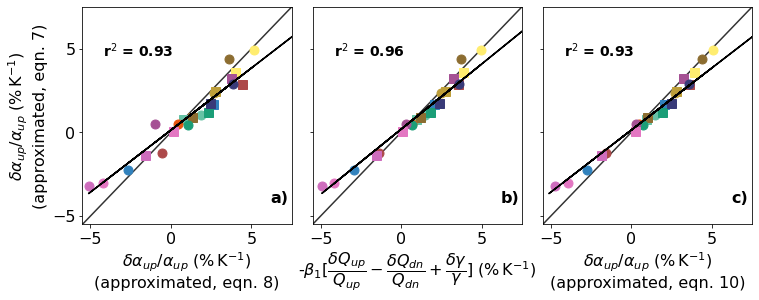

In [20]:
# set up figure
ms = 9
fs = 14
fig, ax = plt.subplots(1,3)
xlim = [-5.5, 7.5]
for i in range(3):
        ax[i].plot(xlim, xlim, 'k-', alpha = 0.8)
c = 0
modcol =0

# loop over models
for k in range(m):
    # loop over temperature differences
    for i in range(2):
        if i==0:
            marker = 'o'
        else:
            marker = 's'

        # plot the approximation in equation 8, against fractional changes in alpha_up
        ax[0].plot( b1_stack[c]*(r_Qup[c] - r_Qdn[c]),r_alpha_up[c], marker = marker, color = cols[modcol], markersize = ms)
        # plot the approximation in equation 8, including fractional changes in gamma, against fractional changes in alpha_up
        ax[1].plot( b1_stack[c]*(r_Qup[c] - r_Qdn[c] + r_gamma[c]),r_alpha_up[c], marker = marker, color = cols[modcol], markersize = ms)
        # plot the approximation in equation 10, against alpha_up
        ax[2].plot( b1_stack[c]*(b2_mn*r_Qcup[c] + b3_mn*r_Qrup[c] - r_Qdn[c] + r_gamma[c]), r_alpha_up[c], marker = marker, color = cols[modcol], markersize = ms)
        c+=1
    modcol+=1

# add in line of best fit and r^2 value (bold if p <0.01)
x = b1_stack*(r_Qup - r_Qdn)
y = r_alpha_up
r2 = funcs.addr2line(x,y,ax[0], position = [0.1, 0.8], plot = True, fontsize = fs)

x = b1_stack*(r_Qup - r_Qdn+ r_gamma)
y = r_alpha_up
r2 = funcs.addr2line(x,y,ax[1], position = [0.1, 0.8], plot = True, fontsize = fs)

x = b1_stack*(b2_stack*r_Qcup + b3_stack*r_Qrup - r_Qdn )
y = r_alpha_up
r2 = funcs.addr2line(x,y,ax[2], position = [0.1, 0.8], plot = True, fontsize = fs)

# add labels
ax[0].set_ylabel('$\delta \\alpha_{up}/\\alpha_{up}$ (%$\,$K$^{-1}$)\n(approximated, eqn. 7)')
ax[0].set_xlabel('$\delta \\alpha_{up}/\\alpha_{up}$ (%$\,$K$^{-1}$)\n(approximated, eqn. 8)')
ax[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=ax[0].transAxes)           

ax[1].set_yticklabels('')
ax[1].set_xlabel('-$\\beta_1 [ \dfrac{\delta Q_{up}}{Q_{up}} - \dfrac{\delta Q_{dn}}{Q_{dn}} +  \dfrac{\delta \gamma}{\gamma}] $ (%$\,$K$^{-1}$)')
ax[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=ax[1].transAxes)           

ax[2].set_yticklabels('')
ax[2].set_xlabel('$\delta \\alpha_{up}/\\alpha_{up}$ (%$\,$K$^{-1}$)\n(approximated, eqn. 10)')
ax[2].text(0.9, 0.1, lets[2], fontweight = 'bold',transform=ax[2].transAxes)           

fig.subplots_adjust(wspace = 0.1)
fig.set_size_inches(12, 4)
plt.setp(ax,xlim = xlim, ylim = xlim, yticks = [-5,0,5])
plt.savefig('revised_plots/FigS8.pdf', bbox_inches = 'tight')

## Figure 8 & Fig S9 - Heating rates agianst alpha_up

Here, we use the fractioanl change variables calculated above to produce the scatter plots in Figure 8.

- Figure 8a shows the difference between the fractional change in Qup - Qdn aginst alpha_up (see equation 8)
- Figure 8b shows the separate components of Qup and Qdn against alpha_up
- Figure 8c shows the separate component of Qcup and Qrup against alpha_up

Fig S9 repeats this with longwave dynamic component on the y axis in place of alpha up

CM1
dam
ICON_LEM_CRM
ICON_NWP_CRM
MESONH
SAM_CRM
SCALE
UCLA-CRM
UKMOi-vn11.0-CASIM
UKMOi-vn11.0-RA1-T
UKMOi-vn11.0-RA1-T-nocloud
WRF_COL_CRM
slope is:  -0.47767007213790896  and standard error is: 0.030514857701594164
slope is:  -0.40669320412591353  and standard error is: 0.07630460809916285
slope is:  0.2030802198184892  and standard error is: 0.12397259568670575
slope is:  -0.48244045849703543  and standard error is: 0.10524987503085352
slope is:  0.040645983651281414  and standard error is: 0.15865420446891845
slope is:  -0.04717942390463659  and standard error is: 0.007672492476194075
slope is:  -0.02041894135980407  and standard error is: 0.013036578065428288
slope is:  0.04558694851336227  and standard error is: 0.01223570592257131
slope is:  -0.02258836911853756  and standard error is: 0.016836681901518727
slope is:  0.007554523999546421  and standard error is: 0.01883868616801663


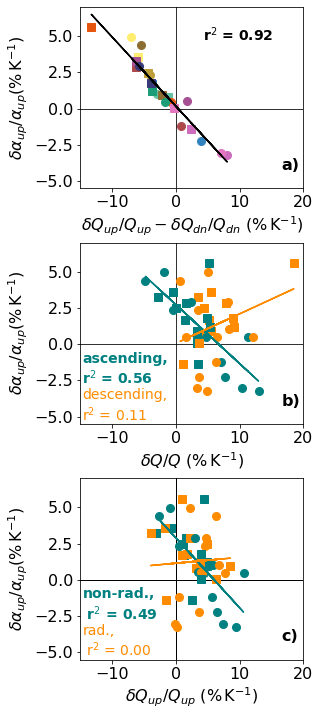

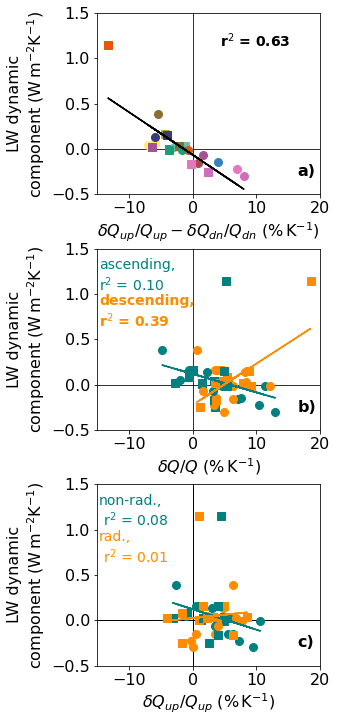

In [38]:
ms= 8

# set up figure 8
first, second, third = 'teal', 'darkorange', 'navy'
cmap ='coolwarm'
fig, ax = plt.subplots(3,1)
xlim, ylim = [-15, 20], [-5.5, 7]


ax[0].plot([0,0], ylim, 'k-', linewidth = 1, alpha = 0.8)
ax[0].plot(xlim, [0, 0], 'k-', linewidth = 1, alpha = 0.8)
ax[1].plot([0,0], ylim, 'k-', linewidth = 1, alpha = 0.8)
ax[1].plot(xlim, [0, 0], 'k-', linewidth = 1, alpha = 0.8)
ax[2].plot([0,0], ylim, 'k-', linewidth = 1)
ax[2].plot(xlim, [0, 0], 'k-', linewidth = 1)

# set up S9
fig1, ax1 = plt.subplots(3,1)
xlim1, ylim1 = [-15, 20], [-0.5, 1.5]

ax1[0].plot([0,0], ylim1, 'k-', linewidth = 1, alpha = 0.8)
ax1[0].plot(xlim1, [0, 0], 'k-', linewidth = 1, alpha = 0.8)
ax1[1].plot([0,0], ylim1, 'k-', linewidth = 1, alpha = 0.8)
ax1[1].plot(xlim1, [0, 0], 'k-', linewidth = 1, alpha = 0.8)
ax1[2].plot([0,0], ylim1, 'k-', linewidth = 1)
ax1[2].plot(xlim1, [0, 0], 'k-', linewidth = 1)

k=0
c=0
for model in models:
    print(model)
    for i in [0,1]:
        if i==0:
            marker = 'o'
        if i==1:
            marker = 's'
         
        ax[0].plot(r_diff_up_down[c], r_alpha_up[c], marker = marker, color = cols[k], markersize = ms)    

        ax[1].plot(r_Qup[c], r_alpha_up[c], marker = marker, color = first, markersize = ms)
        ax[1].plot(r_Qdn[c], r_alpha_up[c], marker = marker , color = second, markersize = ms)

        ax[2].plot(r_Qcup[c], r_alpha_up[c], marker = marker, color = first, markersize = ms)    
        ax[2].plot(r_Qrup[c], r_alpha_up[c], marker = marker , color = second, markersize = ms)

        ax1[0].plot(r_diff_up_down[c], r_dynLW[c], marker = marker, color = cols[k], markersize = ms)    

        ax1[1].plot(r_Qup[c], r_dynLW[c], marker = marker, color = first, markersize = ms)
        ax1[1].plot(r_Qdn[c], r_dynLW[c], marker = marker , color = second, markersize = ms)

        ax1[2].plot(r_Qcup[c], r_dynLW[c], marker = marker, color = first, markersize = ms)    
        ax1[2].plot(r_Qrup[c], r_dynLW[c], marker = marker , color = second, markersize = ms)
        c+=1
    k+=1


# add in lines of best fit Figure 8
x,y,a = r_diff_up_down, r_alpha_up, ax[0]
r2 = funcs.addr2line(x,y,a, color = 'k', position = [0.55, 0.85], fontsize= 14)

x,y,a = r_Qup, r_alpha_up, ax[1]
r2 = funcs.addr2line(x,y,a, color = first, position = [0.01, 0.3], extra_text = 'ascending,\n', fontsize= 14)   

x,y,a = r_Qdn, r_alpha_up, ax[1]
r2 = funcs.addr2line(x,y,a, color = second, position = [0.01, 0.1], extra_text = 'descending,\n', fontsize= 14)  

x,y,a = r_Qcup, r_alpha_up, ax[2]
r2 = funcs.addr2line(x,y,a, color = first, position = [0.01, 0.3], extra_text = 'non-rad.,\n ', fontsize= 14)   

x,y,a = r_Qrup, r_alpha_up, ax[2]
r2 = funcs.addr2line(x,y,a, color = second, position = [0.01, 0.1], extra_text = 'rad.,\n ', fontsize= 14)  

# add in lines of best fit Fig S9
x,y,a = r_diff_up_down, r_dynLW, ax1[0]
r2 = funcs.addr2line(x,y,a, color = 'k', position = [0.55, 0.85], fontsize= 14)

x,y,a = r_Qup, r_dynLW, ax1[1]
r2 = funcs.addr2line(x,y,a, color = first, position = [0.01, 0.85], extra_text = 'ascending,\n', fontsize= 14)   

x,y,a = r_Qdn, r_dynLW, ax1[1]
r2 = funcs.addr2line(x,y,a, color = second, position = [0.01, 0.65], extra_text = 'descending,\n', fontsize= 14)  

x,y,a = r_Qcup, r_dynLW, ax1[2]
r2 = funcs.addr2line(x,y,a, color = first, position = [0.01, 0.85], extra_text = 'non-rad.,\n ', fontsize= 14)   

x,y,a = r_Qrup, r_dynLW, ax1[2]
r2 = funcs.addr2line(x,y,a, color = second, position = [0.01, 0.65], extra_text = 'rad.,\n ', fontsize= 14)

# format Figure 8
ax[0].set_xlabel('$\delta Q_{up}  / Q_{up} -  \delta Q_{dn} /Q_{dn}$ (%$\,$K$^{-1}$)')
ax[0].set_ylabel('$\delta \\alpha_{up} / \\alpha_{up}$(%$\,$K$^{-1}$)')
ax[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=ax[0].transAxes)

ax[1].set_ylabel('$\delta \\alpha_{up} / \\alpha_{up}$(%$\,$K$^{-1}$)')
ax[1].set_xlabel('$\delta Q/Q$ (%$\,$K$^{-1}$)')
ax[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=ax[1].transAxes)
        
ax[2].set_ylabel('$\delta \\alpha_{up} / \\alpha_{up}$(%$\,$K$^{-1}$)')
ax[2].set_xlabel('$\delta Q_{up}/ Q_{up}$ (%$\,$K$^{-1}$)')
ax[2].text(0.9, 0.1, lets[2], fontweight = 'bold',transform=ax[2].transAxes)

fig.subplots_adjust(wspace = 0.05, hspace = 0.3)
fig.set_size_inches(4, 12)
plt.setp(ax, ylim = ylim, xlim = xlim)
fig.savefig('revised_plots/Fig8.pdf', bbox_inches = 'tight')

# Figure  S9
ax1[0].set_xlabel('$\delta Q_{up}  / Q_{up} -  \delta Q_{dn} /Q_{dn}$ (%$\,$K$^{-1}$)')
ax1[0].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')
ax1[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=ax1[0].transAxes)

ax1[1].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')
ax1[1].set_xlabel('$\delta Q/Q$ (%$\,$K$^{-1}$)')
ax1[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=ax1[1].transAxes)
           
ax1[2].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')
ax1[2].set_xlabel('$\delta Q_{up}/ Q_{up}$ (%$\,$K$^{-1}$)')
ax1[2].text(0.9, 0.1, lets[2], fontweight = 'bold',transform=ax1[2].transAxes)

fig1.subplots_adjust(wspace = 0.05, hspace = 0.3)
fig1.set_size_inches(4, 12)
plt.setp(ax1, ylim = ylim1, xlim = xlim1)
fig1.savefig('revised_plots/FigS9.pdf', bbox_inches = 'tight')

## Figure 7 - high cloud fraction

Plots HCF against (a) fractional change in alpha  (b) LW dynamic component of cloud feedback and (c) SW dynamic component of cloud feedback


CM1
dam
ICON_LEM_CRM
ICON_NWP_CRM
MESONH
SAM_CRM
SCALE
UCLA-CRM
UKMOi-vn11.0-CASIM
UKMOi-vn11.0-RA1-T
UKMOi-vn11.0-RA1-T-nocloud
WRF_COL_CRM
slope is:  0.7203932395666871  and standard error is: 0.12451891143330648
slope is:  0.06696951611063204  and standard error is: 0.018700833379319926
slope is:  -0.08784212949647555  and standard error is: 0.028594519819571132


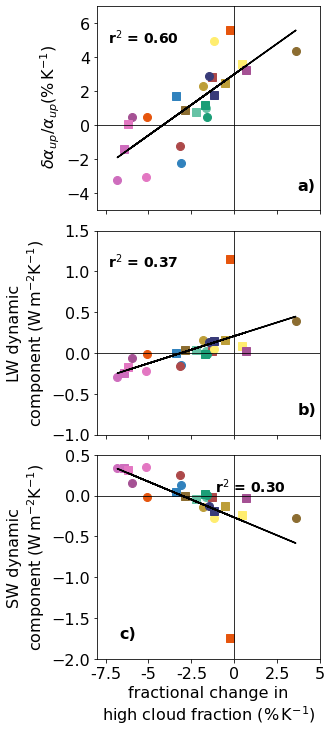

In [36]:
ms = 8
fig3, axes3 = plt.subplots(3,1) # Qcup with pr and LW dynamic, Qcup with hcf and LW dynamic ditto with LCF

# Qcup and lw dynamic effect (colorbar) with pr, HCF and LCF
position1 = [0.05, 0.85]# position for the second insert text
position2 = [0.05, 0.95]# position for the second insert text
col = 'b'
cmap ='coolwarm'
vmin, vmax = -12, 12
ylim1 =[-5,7]
ylim2 = [-1, 1.5]#[-0.6, 0.6]
ylim3 = [-2, 0.5]#[-0.6, 0.6]
xlim = [-8,5]

k=0
c=0
for model in models:
    print(model)
    for i in [0,1]:
        if i==0:
            marker = 'o'
        if i==1:
            marker = 's'
        
 
        axes3[0].plot(r_HCF[c], r_alpha_up[c], marker = marker, color = cols[k], markersize = ms)
        axes3[1].plot(r_HCF[c], r_dynLW[c], marker = marker, color = cols[k], markersize = ms)
        axes3[2].plot(r_HCF[c], r_dynSW[c], marker = marker, color = cols[k], markersize = ms)
        c+=1
    k+=1

# format subplot (a)
axes3[0].plot([0,0], ylim1, 'k-', linewidth = 1, alpha = 0.8)
axes3[0].set_ylim(ylim1)
axes3[0].plot(xlim, [0,0], 'k-', linewidth = 1, alpha = 0.8)
axes3[0].set_xlim(xlim)
axes3[0].set_xticks([-7.5,-5, -2.5, 0, 2.5, 5])

# add in line of best fit, r^2 value (bold if p< 0.01)
r2 = funcs.addr2line(r_HCF,r_alpha_up,axes3[0],position = position1, fontsize= 14)
axes3[0].set_xticklabels([])
axes3[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=axes3[0].transAxes)
axes3[0].set_ylabel(' $\delta \\alpha_{up} / \\alpha_{up}$(%$\,$K$^{-1}$)')

# same for (b)
axes3[1].plot([0,0], ylim2, 'k-', linewidth = 1, alpha = 0.8)
axes3[1].set_ylim(ylim2)
axes3[1].plot(xlim, [0,0], 'k-', linewidth = 1, alpha = 0.8)
axes3[1].set_xlim(xlim)
axes3[1].set_xticks([-7.5,-5, -2.5, 0, 2.5, 5])
axes3[1].set_xticklabels([])

r2 = funcs.addr2line(r_HCF,r_dynLW,axes3[1],position = position1, fontsize= 14)
axes3[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=axes3[1].transAxes)
axes3[1].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')

# same for (c)
axes3[2].plot([0,0], ylim3, 'k-', linewidth = 1, alpha = 0.8)
axes3[2].set_ylim(ylim3)
axes3[2].plot(xlim, [0,0], 'k-', linewidth = 1, alpha = 0.8)
axes3[2].set_xlim(xlim)
axes3[2].set_xticks([-7.5,-5, -2.5, 0, 2.5, 5])
axes3[2].set_xticklabels([-7.5,-5, -2.5, 0, 2.5, 5])
axes3[2].set_xlabel('fractional change in\nhigh cloud fraction (%$\,$K$^{-1}$)')

r2 = funcs.addr2line(r_HCF,r_dynSW,axes3[2],position = [0.53, 0.85], fontsize= 14)
axes3[2].text(0.1, 0.1, lets[2], fontweight = 'bold',transform=axes3[2].transAxes)
axes3[2].set_ylabel('SW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')

fig3.subplots_adjust(hspace = 0.1)
fig3.set_size_inches(4, 12)
fig3.savefig('revised_plots/Fig7.pdf', bbox_inches = 'tight')



## Figure S5 - same as HCF plot, but for low cloud

CM1
dam
ICON_LEM_CRM
ICON_NWP_CRM
MESONH
SAM_CRM
SCALE
UCLA-CRM
UKMOi-vn11.0-CASIM
UKMOi-vn11.0-RA1-T
UKMOi-vn11.0-RA1-T-nocloud
WRF_COL_CRM
slope is:  0.21077759163569948  and standard error is: 0.13617372958011184
slope is:  0.02095823159747781  and standard error is: 0.016468295602975146
slope is:  -0.03153465785023617  and standard error is: 0.023860872935282447


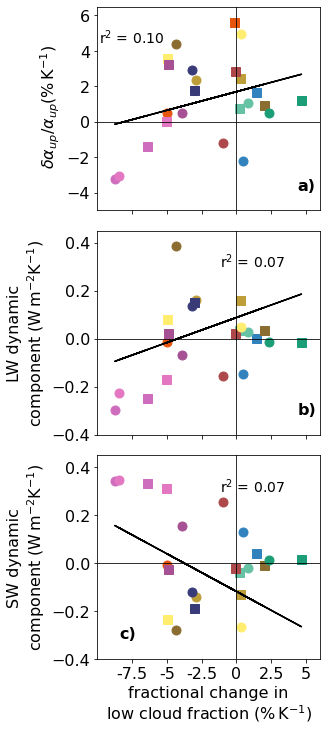

In [27]:
ms = 9
fig3, axes3 = plt.subplots(3,1) # Qcup with pr and LW dynamic, Qcup with hcf and LW dynamic ditto with LCF

# Qcup and lw dynamic effect (colorbar) with pr, HCF and LCF
position1 = [0.01, 0.85]# position for the second insert text
position2 = [0.01, 0.95]# position for the second insert text
col = 'b'
cmap ='coolwarm'
vmin, vmax = -12, 12
ylim1 =[-5,6.5]
ylim2 = [-0.4, 0.45]
ylim3 = [-0.4, 0.45]
xlim = [-10,6]

k=0
c=0
for model in models:
    print(model)
    for i in [0,1]:
        if i==0:
            marker = 'o'
        if i==1:
            marker = 's'
        

        axes3[0].plot(r_LCF[c], r_alpha_up[c], marker = marker, color = cols[k], markersize = ms)
        axes3[1].plot(r_LCF[c], r_dynLW[c], marker = marker, color = cols[k], markersize = ms)
        axes3[2].plot(r_LCF[c], r_dynSW[c], marker = marker, color = cols[k], markersize = ms)
        c+=1
    k+=1



axes3[0].plot([0,0], ylim1, 'k-', linewidth = 1, alpha = 0.8)
axes3[0].set_ylim(ylim1)
axes3[0].plot(xlim, [0,0], 'k-', linewidth = 1, alpha = 0.8)
axes3[0].set_xlim(xlim)
axes3[0].set_xticks([-7.5,-5, -2.5, 0, 2.5, 5])

r2 = funcs.addr2line(r_LCF,r_alpha_up,axes3[0],position = position1, fontsize= 14)

axes3[0].set_xticklabels([])
axes3[0].text(0.9, 0.1, lets[0], fontweight = 'bold',transform=axes3[0].transAxes)
axes3[0].set_ylabel(' $\delta \\alpha_{up} / \\alpha_{up}$(%$\,$K$^{-1}$)')

axes3[1].plot([0,0], ylim2, 'k-', linewidth = 1, alpha = 0.8)
axes3[1].set_ylim(ylim2)
axes3[1].plot(xlim, [0,0], 'k-', linewidth = 1, alpha = 0.8)
axes3[1].set_xlim(xlim)
axes3[1].set_xticks([-7.5,-5, -2.5, 0, 2.5, 5])
axes3[1].set_xticklabels([])

r2 = funcs.addr2line(r_LCF,r_dynLW,axes3[1],position = [0.55, 0.85], fontsize= 14)

axes3[1].text(0.9, 0.1, lets[1], fontweight = 'bold',transform=axes3[1].transAxes)
axes3[1].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')


axes3[2].plot([0,0], ylim3, 'k-', linewidth = 1, alpha = 0.8)
axes3[2].set_ylim(ylim3)
axes3[2].plot(xlim, [0,0], 'k-', linewidth = 1, alpha = 0.8)
axes3[2].set_xlim(xlim)
axes3[2].set_xticks([-7.5,-5, -2.5, 0, 2.5, 5])
axes3[2].set_xticklabels([-7.5,-5, -2.5, 0, 2.5, 5])
axes3[2].set_xlabel('fractional change in\nlow cloud fraction (%$\,$K$^{-1}$)')

r2 = funcs.addr2line(r_LCF,r_dynSW,axes3[2],position = [0.55, 0.85], fontsize= 14)

axes3[2].text(0.1, 0.1, lets[2], fontweight = 'bold',transform=axes3[2].transAxes)
axes3[2].set_ylabel('SW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')


fig3.subplots_adjust(hspace = 0.1)
fig3.set_size_inches(4, 12)
fig3.savefig('revised_plots/FigS5.pdf', bbox_inches = 'tight')

